# **Risk Management: Value at Risk and Expected Shortfall**
In the previous work on portfolio optimization we just find the optimal weights for each asset to incorporate on our portfolio. Now we'll focus on the other side of this problem, i.e., focus on risk assessment of this optimized portfolio. To do that we'll consider the optimal weights calculated in 09/10/2024 with [Portfolio Optimization Jupyter Notebook](https://github.com/MarioCastilloM/Modern-Portfolio-Theory/blob/main/Portfolio_Oprimization_a_Realistic_Approach.ipynb).

In the Risk Management's framework we found multiples metrics to quantify the risk. Between that, two of the more used and useful are the **Value at Risk (VaR)** and **Expected Shortfall (ES)**. Let's dig into this:

1.- **VaR** measures the maximum expected loss over a given time period at a certain confidence level. For example, a 1-day VaR at 95% confidence level is the maximum loss expected (with 95% confidence) over one day. How much can I loss in one day.

2.- **ES** also known as **Conditional VaR (CVaR)** it provides the expected loss in the worst-case scenarios beyond the VaR threshold. It gives an average of the losses that occur beyond the VaR level. Is the average of the tail of the distribution after the VaR.

So, we need to calculate the VaR to obtain the ES and given that, we have to define how we'll calculate the VaR:

a.- Parametric Method (Analytical VaR) assuming normality of returns.

b.- Monte Carlo Simulation simulating a large number of possible portfolio returns to estimate VaR and ES.

The assumptions are: 1 day time horizon and 95% of confidence. Additionally we'll use the optimal weights previously obtained in *Portfolio Optimization Jupyter Notebook*.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from dateutil.relativedelta import relativedelta
import datetime as dt
from scipy.stats import norm
import seaborn as sns
from scipy.stats import chi2
%matplotlib inline

The first step will be retrieve the stocks data to calculate the daily return of each asset.

In [2]:
fixed_income = ['IEF']  # iShares 7-10 Year Treasury Bond ETF (IEF)
latam_stocks = ['ILF']  # iShares Latin America 40 ETF (ILF)
usa_stocks = ['AAPL', 'TSLA', 'AMZN']  # USA Stocks

tickers = fixed_income + latam_stocks + usa_stocks

horizon = 5
end = dt.date.today()
start = end - relativedelta(years=horizon)

data = yf.download(tickers, start=start, end=end)['Adj Close']

data.dropna(inplace=True)

[*********************100%***********************]  5 of 5 completed


In [3]:
returns = data.pct_change().dropna()

Once we get the returns dataframe we can use the optimal weights obtained previously and calculate the total portfolio return. Then we get the mean and standard deviation to calculate parametric **VaR** and **ES**.

In [4]:
optimal_weights_sharpe = np.array([0.4, 0.1, 0.3, 0.15, 0.05])

In [5]:
portfolio_returns = returns.dot(optimal_weights_sharpe)

In [6]:
portfolio_mean = portfolio_returns.mean()
portfolio_std = portfolio_returns.std()

## **Parametric VaR and ES**

Here we define the parametric VaR and ES functions following:

- $VaR = μ + σ*z_α$
- $ES = μ + σ*\frac{𝛷(z_α)}{(1-α)}$

In [7]:
def parametric_var(mean, std, confidence_level=0.95):
  z = norm.ppf(1 - confidence_level)
  var = mean + z * std
  return var

In [8]:
var_95 = parametric_var(portfolio_mean, portfolio_std)
var_99 = parametric_var(portfolio_mean, portfolio_std, confidence_level=0.99)

In [9]:
def parametric_es(mean, std, confidence_level=0.95):
  z = norm.ppf(1 - confidence_level)
  es = - (mean + (norm.pdf(z) / (1 - confidence_level)) * std)
  return es

In [10]:
es_95 = parametric_es(portfolio_mean, portfolio_std)
es_99 = parametric_es(portfolio_mean, portfolio_std, confidence_level=0.99)

In [11]:
confidence_levels = [0.95, 0.99]
parametric_results = {}
for cl in confidence_levels:
  var = parametric_var(portfolio_mean, portfolio_std, confidence_level=cl)
  es = parametric_es(portfolio_mean, portfolio_std, confidence_level=cl)
  parametric_results[cl] = {'VaR': var, 'ES': es}

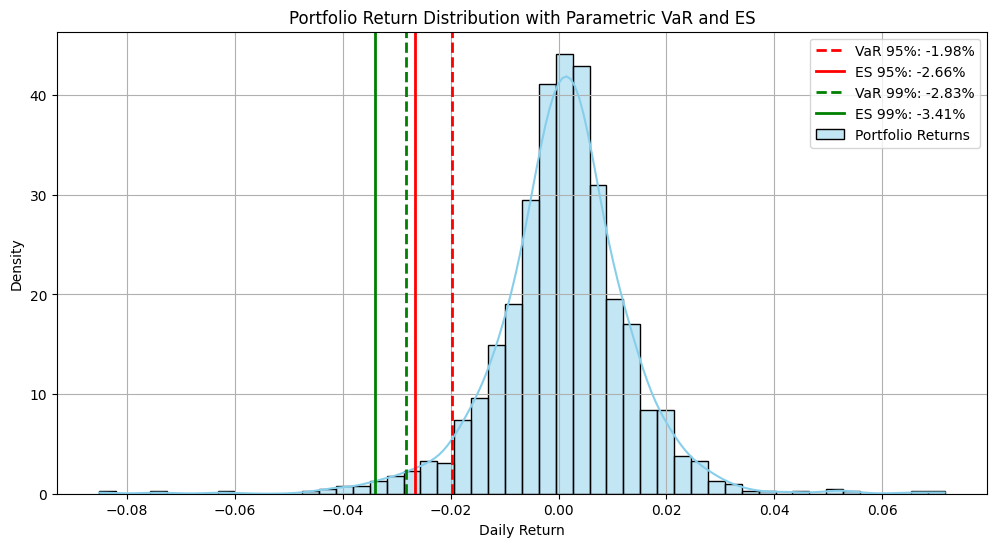

In [12]:
plt.figure(figsize=(12, 6))

sns.histplot(portfolio_returns, bins=50, kde=True, color='skyblue', stat='density', label='Portfolio Returns')

colors = {0.95: 'red', 0.99: 'green'}

for cl in confidence_levels:
    var = parametric_results[cl]['VaR']
    es = parametric_results[cl]['ES']

    plt.axvline(var, color=colors[cl], linestyle='--', linewidth=2,
                label=f'VaR {int(cl*100)}%: {var:.2%}')

    plt.axvline(es, color=colors[cl], linestyle='-', linewidth=2,
                label=f'ES {int(cl*100)}%: {es:.2%}')

plt.title('Portfolio Return Distribution with Parametric VaR and ES')
plt.xlabel('Daily Return')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

Histogram & KDE shows the distribution of portfolio's daily returns.

VaR Lines represent the threshold beyond which losses are expected to occur with a certain confidence level. For example, at 95% confidence, we expect that 5% of the time, losses will exceed the VaR value.

ES Lines provide the average loss expected in the worst-case scenarios beyond the VaR threshold. It gives a sense of how bad the losses could be when they exceed VaR.

## **Monte Carlo Simulation**

This method simulates the portfolio's returns based on its mean and covariance matrix. So first we'll simulate te returns:

In [13]:
num_simulation = 10000
time_horizon = 1

simulated_portfolio_returns = np.random.normal(portfolio_mean, portfolio_std, num_simulation)

In [14]:
var_95_mc = np.percentile(simulated_portfolio_returns, 100 * (1 - 0.95))
var_99_mc = np.percentile(simulated_portfolio_returns, 100 * (1 - 0.99))

es_95_mc = simulated_portfolio_returns[simulated_portfolio_returns <= var_95_mc].mean()
es_99_mc = simulated_portfolio_returns[simulated_portfolio_returns <= var_99_mc].mean()

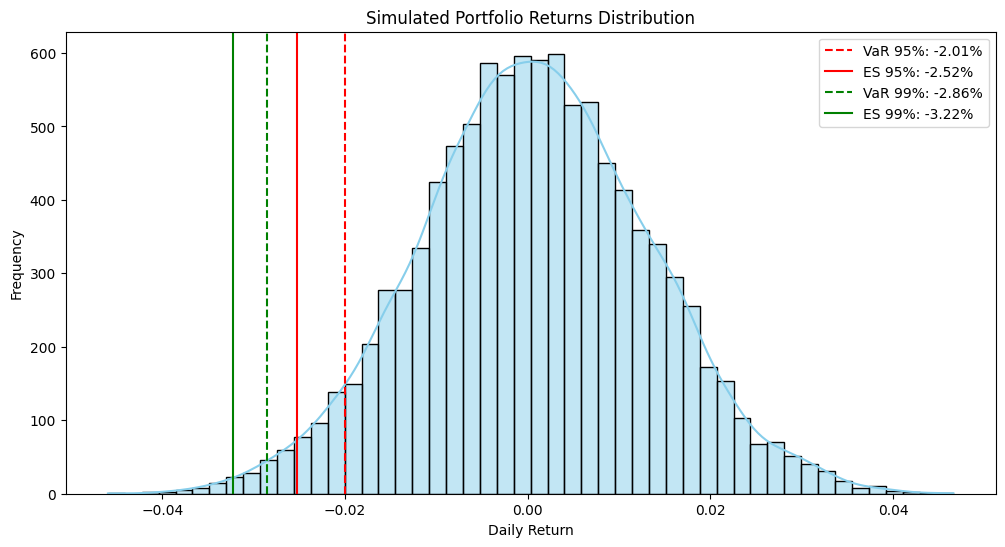

In [15]:
plt.figure(figsize=(12,6))
sns.histplot(simulated_portfolio_returns, bins=50, kde=True, color='skyblue')
plt.title('Simulated Portfolio Returns Distribution')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')

plt.axvline(var_95_mc, color='r', linestyle='--', label=f'VaR 95%: {var_95_mc:.2%}')
plt.axvline(es_95_mc, color='r', linestyle='-', label=f'ES 95%: {es_95_mc:.2%}')
plt.axvline(var_99_mc, color='g', linestyle='--', label=f'VaR 99%: {var_99_mc:.2%}')
plt.axvline(es_99_mc, color='g', linestyle='-', label=f'ES 99%: {es_99_mc:.2%}')

plt.legend()
plt.show()

## **Historical VaR and ES**
In the previous approaches we assumed returns distributed normally. Alternatively to that we can the hisotrical returns to calculate both **VaR** and **ES**:

In [16]:
sorted_returns = portfolio_returns.sort_values()

var_95_hist = np.percentile(sorted_returns, 100 * (1 - 0.95))
var_99_hist = np.percentile(sorted_returns, 100 * (1 - 0.99))

es_95_hist = sorted_returns[sorted_returns <= var_95_hist].mean()
es_99_hist = sorted_returns[sorted_returns <= var_99_hist].mean()

If returns are approximately normal, Monte Carlo Simulation and Parametric approaches should be similar. Otherwise, Monte Carlo Simulation provides more accurate risk estimates through better capturing skewness or kurtosis.

Regarding the Historical approach, it captures the empirical distribution features, but may not predict future risks if historical patterns change.

## **Backtesting**
Now we want to test how the metrcis perform compared with real data, i.e., check if given a period of time, the actual losses have exceded VaR and how many times. To do this, we'll consider a 250 days rolling window, calculate VaR for each day moving forward one step a time the rolling window and record when the losses exceed the VaR.

In [17]:
window = 250
confidence_level = 0.95

var_history = []
es_history = []
actual_returns = []
exceeded_var_count = []

portfolio_returns_series = pd.Series(portfolio_returns, index=returns.index[1:])

for i in range(window, len(portfolio_returns_series)):
    rolling_returns = portfolio_returns_series.iloc[i-window:i]
    var = np.percentile(rolling_returns, 100 * (1 - confidence_level))
    var_history.append(var)

    es = rolling_returns[rolling_returns <= var].mean()
    es_history.append(es)

    actual_return = portfolio_returns_series.iloc[i]
    actual_returns.append(actual_return)
    if actual_return < var:
        exceeded_var_count.append(1)
    else:
        exceeded_var_count.append(0)

In [18]:
backtest_results = pd.DataFrame({
    'VaR': var_history,
    'ES': es_history,
    'Actual Return': actual_returns,
    'Exception': exceeded_var_count
}, index=portfolio_returns_series.index[window:])

backtest_results.head()

,VaR,ES,Actual Return,Exception
Date,,,,
2020-10-21 00:00:00+00:00,-0.028987,-0.04491,-0.002554,0
2020-10-22 00:00:00+00:00,-0.028987,-0.04491,-0.002249,0
2020-10-23 00:00:00+00:00,-0.028987,-0.04491,-0.002342,0
2020-10-26 00:00:00+00:00,-0.028987,-0.04491,-0.000373,0
2020-10-27 00:00:00+00:00,-0.028987,-0.04491,0.005948,0


In [19]:
num_exceptions = sum(backtest_results['Exception'])

num_observations = len(backtest_results)

expected_exceptions = num_observations * (1 - confidence_level)

exception_rate = num_exceptions / num_observations

print(f"Number of exceptions: {num_exceptions}")
print(f"Total observations: {num_observations}")
print(f"Expected exceptions: {expected_exceptions:.2f}")
print(f"Exception rate: {exception_rate:.2%}")

Number of exceptions: 46
Total observations: 1006
Expected exceptions: 50.30
Exception rate: 4.57%


Now we want to check wheter the number of times actual losses exceed the VaR estimates aligns with with the expected frequency based on the chosen confidence level. To do that we'll use the **Kupiec's POF test**. This test consider $𝓗_0:$ *The model accuratly predicts the proportion of exceptions (e.g., 5% for 95% confidence level)* and $𝓗_1:$ *The model does not accuratly predict the proportion of exceptions*. The statistic is the likelihood ratio based on the observed number of exceptions versus expected and it's compared with the critical value of $χ^2$ distribution to decide wether to reject $𝓗_0$.

In [20]:
def kupiec_pof_test(num_exceptions, num_observations, confidence_level):
    # Expected exception probability
    p = 1 - confidence_level

    # Log-likelihood under null hypothesis
    log_likelihood_null = num_observations * np.log(1 - p)

    # Log-likelihood under alternative hypothesis
    log_likelihood_alternative = (num_exceptions * np.log(p) +
                                  (num_observations - num_exceptions) * np.log(1 - p))

    # Test statistic
    LR_pof = -2 * (log_likelihood_null - log_likelihood_alternative)

    # P-value
    p_value = 1 - chi2.cdf(LR_pof, df=1)

    return LR_pof, p_value

# Perform Kupiec's test
LR_pof, p_value = kupiec_pof_test(num_exceptions, num_observations, confidence_level)

print(f"Kupiec's POF Test Statistic: {LR_pof:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Reject the null hypothesis: The model does not accurately predict VaR exceptions.")
else:
    print("Fail to reject the null hypothesis: The model accurately predicts VaR exceptions.")


Kupiec's POF Test Statistic: -270.8884
P-value: 1.0000
Fail to reject the null hypothesis: The model accurately predicts VaR exceptions.


Finally we plot the results of rolling **VaR** over the actual returns and shaded the exceptions zone.

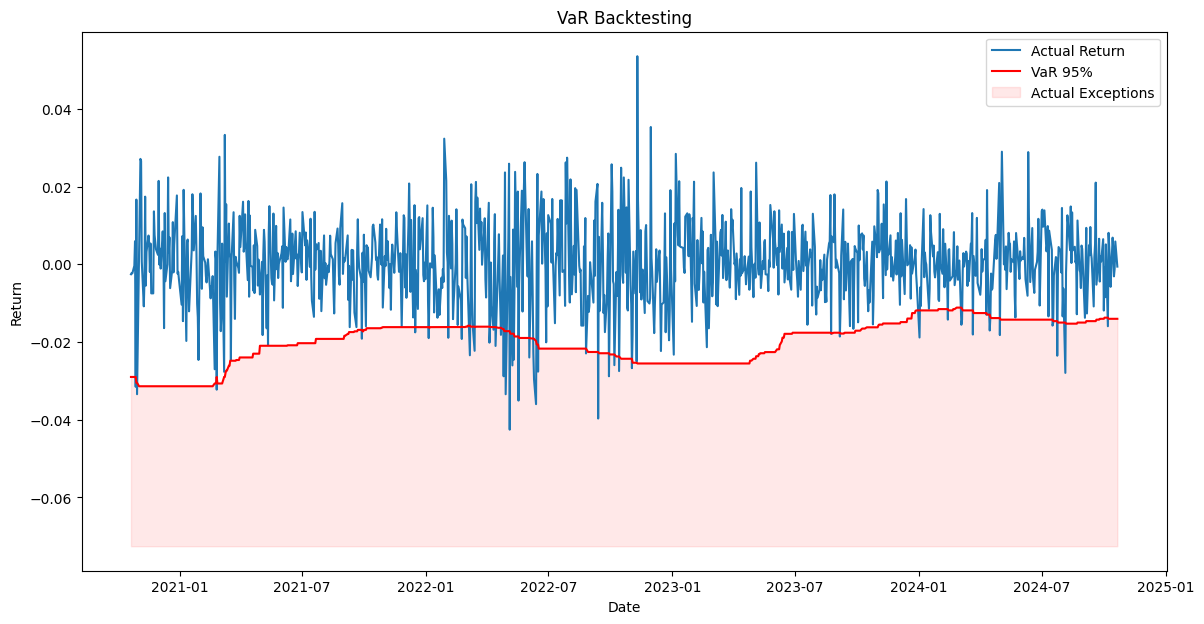

In [21]:
plt.figure(figsize=(14,7))
plt.plot(backtest_results.index, backtest_results['Actual Return'], label='Actual Return')
plt.plot(backtest_results.index, backtest_results['VaR'], color='red', label=f'VaR {int(confidence_level*100)}%')
y_min = backtest_results['Actual Return'].min() - 0.03
plt.fill_between(backtest_results.index,
                 backtest_results['VaR'],
                 y_min,
                 color='red', alpha=0.09, label='Actual Exceptions', interpolate=True, zorder=1)
plt.legend()
plt.title('VaR Backtesting')
plt.xlabel('Date')
plt.ylabel('Return')
plt.show()

## **Final Remarks**

In this project, we delved into the critical aspects of financial risk management by focusing on **Value at Risk (VaR)** and **Expected Shortfall (ES)** as key risk metrics. These metrics are essential for understanding and quantifying the potential losses in a portfolio, making them indispensable tools for both investors and risk managers.

**VaR** offers a clear and straightforward measure of potential downside risk, allowing stakeholders to gauge the maximum expected loss over a given time frame.

**ES**, also known as Conditional VaR, goes a step further by measuring the average loss that occurs beyond the VaR threshold. While VaR indicates the worst-case scenario at a certain confidence level, ES provides insight into the severity of losses in extreme market conditions, offering a more comprehensive view of tail risk.

In this project, we applied VaR and ES through both **parametric** and **Monte Carlo simulation** methods. Additionally, we implemented **backtesting** to validate the accuracy of our VaR and ES estimates.

By integrating VaR and ES into our portfolio analysis, we not only quantified the potential risks but also validated our risk models through rigorous backtesting. This comprehensive approach ensures that the portfolio is well-positioned to withstand adverse market conditions, aligning with both investment objectives and risk tolerance levels.

In Summary, leveraging VaR and ES provided a robust framework for assessing and managing portfolio risks. These metrics are invaluable for understanding the potential downside, guiding strategic investment decisions, and ensuring that risk management practices are both effective and compliant with industry standards.